In [ ]:
import json
import re
import pandas as pd
import os
import matplotlib.font_manager as font_manager
from mplsoccer import VerticalPitch


In [ ]:
font_path_regular = '/Users/alfonsomarino/Desktop/Teko/static/Teko-Regular.ttf'
# Create a font properties object with the font file
font_normal = font_manager.FontProperties(fname=font_path_regular)

font_path_med = "/Users/alfonsomarino/Desktop/Teko/static/Teko-Medium.ttf"
font_med = font_manager.FontProperties(fname = font_path_med)

font_path_semi = "/Users/alfonsomarino/Desktop/Teko/static/Teko-SemiBold.ttf"
font_semi = font_manager.FontProperties(fname = font_path_semi)

In [ ]:
#lista_file = ['/Users/alfonsomarino/Desktop/Bayern Munich 1-2 Inter - Champions League 2024:2025 - Live.html']

cartella = '/Users/alfonsomarino/Desktop/partite/partite el'

# Crea una lista con i percorsi completi dei file nella cartella
lista_file = [os.path.join(cartella, f) for f in os.listdir(cartella) if os.path.isfile(os.path.join(cartella, f))]



In [ ]:
def extract_json_from_html(html_path, save_output=False):
    html_file = open(html_path, 'r')
    html = html_file.read()
    html_file.close()
    regex_pattern = r'(?<=require\.config\.params\["args"\].=.)[\s\S]*?;'
    data_txt = re.findall(regex_pattern, html)[0]

    # add quotations for json parser
    data_txt = data_txt.replace('matchId', '"matchId"')
    data_txt = data_txt.replace('matchCentreData', '"matchCentreData"')
    data_txt = data_txt.replace('matchCentreEventTypeJson', '"matchCentreEventTypeJson"')
    data_txt = data_txt.replace('formationIdNameMappings', '"formationIdNameMappings"')
    data_txt = data_txt.replace('};', '}')

    if save_output:
        # save json data to txt
        output_file = open(f"{html_path}.txt", "wt")
        n = output_file.write(data_txt)
        output_file.close()

    return data_txt

In [ ]:
def extract_data_from_dict(data):
    # load data from json
    event_types_json = data["matchCentreEventTypeJson"]
    formation_mappings = data["formationIdNameMappings"]
    events_dict = data["matchCentreData"]["events"]
    teams_dict = {data["matchCentreData"]['home']['teamId']: data["matchCentreData"]['home']['name'],
                  data["matchCentreData"]['away']['teamId']: data["matchCentreData"]['away']['name']}
    players_dict = data["matchCentreData"]["playerIdNameDictionary"]
    # create players dataframe
    players_home_df = pd.DataFrame(data["matchCentreData"]['home']['players'])
    players_home_df["teamId"] = data["matchCentreData"]['home']['teamId']
    players_away_df = pd.DataFrame(data["matchCentreData"]['away']['players'])
    players_away_df["teamId"] = data["matchCentreData"]['away']['teamId']
    players_df = pd.concat([players_home_df, players_away_df])
    players_ids = data["matchCentreData"]["playerIdNameDictionary"]
    return events_dict, players_df, teams_dict

In [ ]:
def process_multiple_files(html_file_paths):
    all_events = []
    all_players = []
    all_teams = {}

    for match_html_path in html_file_paths:
        # Estrai i dati JSON dal file HTML
        json_data_txt = extract_json_from_html(match_html_path)
        data = json.loads(json_data_txt)

        # Estrai i dati dagli eventi, giocatori e squadre
        events_dict, players_df, teams_dict = extract_data_from_dict(data)

        # Aggiungi i dati estratti all'insieme globale
        all_events.extend(events_dict)  # Unisce tutti gli eventi
        all_players.append(players_df)  # Lista dei DataFrame dei giocatori
        all_teams.update(teams_dict)    # Aggiorna il dizionario delle squadre

    # Combina i DataFrame dei giocatori in un unico DataFrame
    combined_players_df = pd.concat(all_players, ignore_index=True)

    return all_events, combined_players_df, all_teams

all_events, combined_players_df, all_teams = process_multiple_files(lista_file)

In [ ]:
def get_events_df(events_dict):
    df = pd.DataFrame(events_dict)
    df['eventType'] = df.apply(lambda row: row['type']['displayName'], axis=1)
    df['outcomeType'] = df.apply(lambda row: row['outcomeType']['displayName'], axis=1)

    # create receiver column based on the next event
    # this will be correct only for successfull passes
    #df["receiver"] = df["playerId"].shift(-1)

    # filter only passes
    #passes_ids = df.index[df['eventType'] == 'Pass']
    #df_passes = df.loc[
    #    passes_ids, ["id","minute", "x", "y", "endX", "endY", "teamId", "playerId", "receiver", "eventType", "outcomeType"]]
    df_touch = df[["id","minute", "x", "y", "endX", "endY", "teamId", "playerId", "isTouch", "eventType", "outcomeType"]]

    return df_touch

In [ ]:
df_touch = get_events_df(all_events)
df = df_touch[df_touch["playerId"] == 486734] #whoscored ID
df

,id,minute,x,y,endX,endY,teamId,playerId,isTouch,eventType,outcomeType
716,2.753071e+09,45,0.0,0.0,NaN,NaN,309,486734.0,False,SubstitutionOn,Successful
754,2.753073e+09,46,24.6,41.9,NaN,NaN,309,486734.0,True,Tackle,Successful
755,2.753073e+09,46,26.3,42.5,27.7,37.2,309,486734.0,True,Pass,Unsuccessful
762,2.753074e+09,47,12.9,64.0,8.4,57.3,309,486734.0,True,Pass,Successful
779,2.753075e+09,48,57.6,73.2,NaN,NaN,309,486734.0,False,BallRecovery,Successful
...,...,...,...,...,...,...,...,...,...,...,...
38164,2.773839e+09,83,27.5,93.8,31.0,86.3,309,486734.0,True,Pass,Successful
38251,2.773845e+09,89,29.2,26.5,31.2,11.6,309,486734.0,True,Pass,Unsuccessful
38256,2.773845e+09,89,20.8,24.7,NaN,NaN,309,486734.0,False,BallRecovery,Successful
38257,2.773845e+09,89,20.8,24.7,40.0,8.5,309,486734.0,True,Pass,Unsuccessful


In [ ]:
df["eventType"].unique()

array(['SubstitutionOn', 'Tackle', 'Pass', 'BallRecovery', 'Dispossessed',
       'TakeOn', 'BallTouch', 'Foul', 'Challenge', 'Clearance',
       'CornerAwarded', 'Save', 'BlockedPass', 'Aerial', 'Card',
       'Interception', 'SavedShot', 'OffsideProvoked', 'OffsidePass',
       'MissedShots', 'Goal', 'SubstitutionOff'], dtype=object)

In [ ]:
df = df[df["eventType"] == "BallRecovery"]

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

almond_cmap = LinearSegmentedColormap.from_list("Almond - 100 colors",
                                                  ['blanchedalmond', 'darkred'], N =100)

In [ ]:
len(df)

90

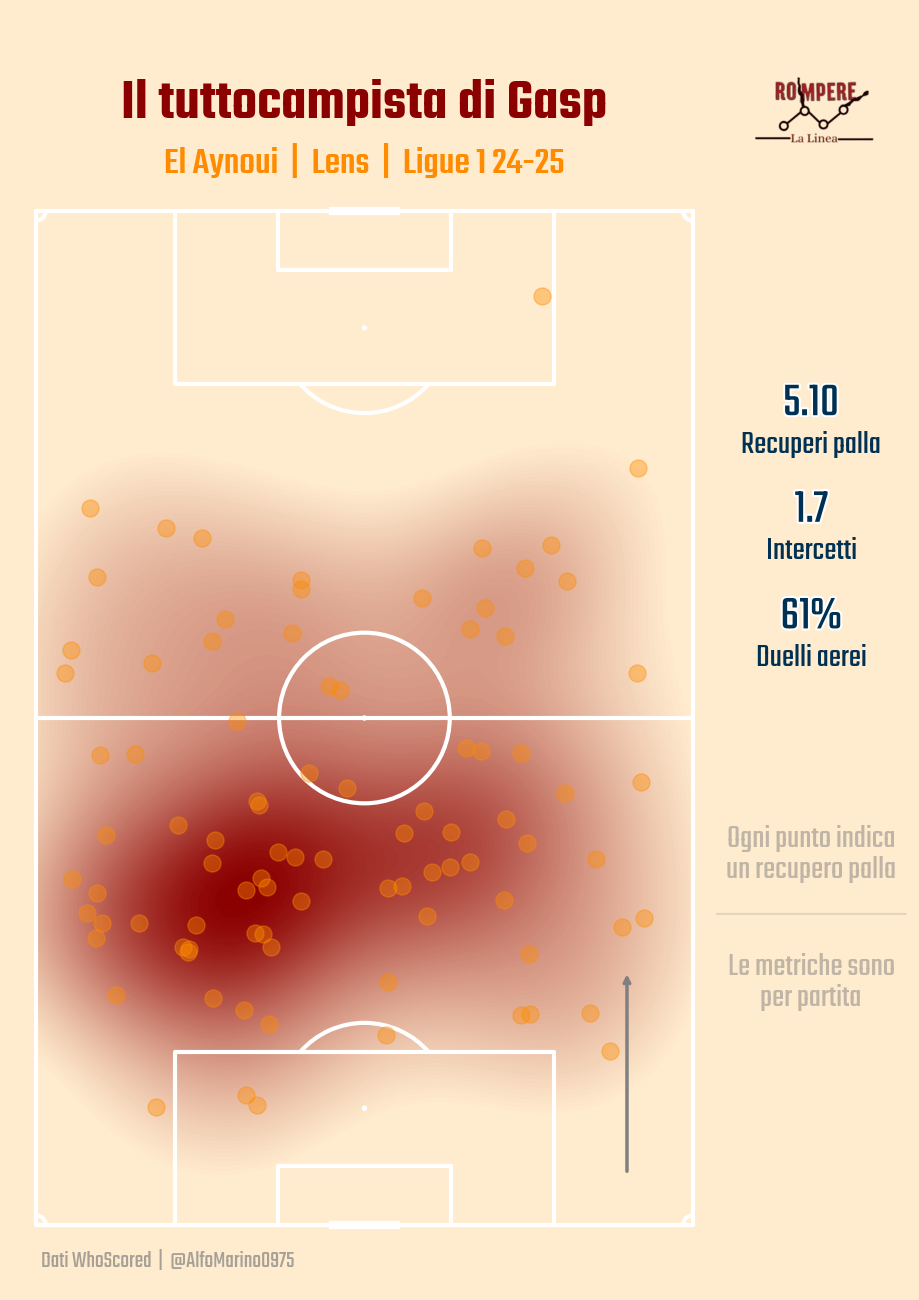

In [ ]:
from matplotlib.patches import RegularPolygon
from highlight_text import fig_text, ax_text
import matplotlib.patheffects as path_effects
import os
import matplotlib.image as image
import matplotlib.pyplot as plt


import matplotlib.patheffects as path_effects

path_eff = [path_effects.Stroke(linewidth=3, foreground='white'),
            path_effects.Normal()]


def getImage(path):
   return OffsetImage(plt.imread(path), zoom=0.9)

pitch = VerticalPitch(pitch_type='opta', corner_arcs=True, pitch_color = "blanchedalmond", line_color="white", line_alpha=1, linewidth = 3)

fig, axs = pitch.grid(figheight=13, title_height=0.08, endnote_space=0, title_space=0,
                      axis=False, ncols = 1,
                      grid_height=0.82, endnote_height=0.03)
fig.patch.set_facecolor('blanchedalmond')
#ax.set_facecolor('blanchedalmond')

pitch.scatter(df["x"], df["y"], s= 150, ax = axs["pitch"], c= "darkorange", alpha=.4)
pitch.kdeplot(df.x, df.y, ax=axs['pitch'],
                    # fill using 100 levels so it looks smooth
                    fill=True, levels=1000, zorder = -1,
                    cmap= almond_cmap)


#1, 0.5
axs['endnote'].text(0.2, 0.8, 'Dati WhoScored  |  @AlfoMarino0975', va='center', ha='center', fontsize=17, 
                    color = "grey", alpha = 0.7, fontproperties = font_normal)



# Aggiungi sottotitolo per il primo campo
axs['pitch'].text(0.5, 1.04, "El Aynoui  |  Lens  |  Ligue 1 24-25", va='top', ha='center', fontsize=28, 
                     fontproperties = font_med, color='darkorange', transform=axs['pitch'].transAxes)

axs['pitch'].text(1.13, 0.77, "Recuperi palla", va='top', ha='center', fontsize=24, 
                    fontproperties = font_normal, color='#003153', transform=axs['pitch'].transAxes)

axs['pitch'].text(1.13, 0.815, "5.10", va='top', ha='center', fontsize=35, 
                    fontproperties = font_normal, color='#003153', transform=axs['pitch'].transAxes, path_effects = path_eff)

axs['pitch'].text(1.13, 0.67, "Intercetti", va='top', ha='center', fontsize=24, 
                    fontproperties = font_normal, color='#003153', transform=axs['pitch'].transAxes)

axs['pitch'].text(1.13, 0.715, "1.7", va='top', ha='center', fontsize=35, 
                    fontproperties = font_normal, color='#003153', transform=axs['pitch'].transAxes, path_effects = path_eff)

axs['pitch'].text(1.13, 0.57, "Duelli aerei", va='top', ha='center', fontsize=24, 
                    fontproperties = font_normal, color='#003153', transform=axs['pitch'].transAxes)

axs['pitch'].text(1.13, 0.615, "61%", va='top', ha='center', fontsize=35, 
                    fontproperties = font_normal, color='#003153', transform=axs['pitch'].transAxes, path_effects = path_eff)

axs['pitch'].text(1.13, 0.4, "Ogni punto indica\nun recupero palla", va='top', ha='center', fontsize=24, 
                    fontproperties = font_normal, color='gray', alpha = 0.5, transform=axs['pitch'].transAxes)

axs['pitch'].text(1.13, 0.34, "____________", va='top', ha='center', fontsize=24, 
                    fontproperties = font_normal, color='gray', alpha = 0.2, transform=axs['pitch'].transAxes)

axs['pitch'].text(1.13, 0.28, "Le metriche sono\nper partita", va='top', ha='center', fontsize=24, 
                    fontproperties = font_normal, color='gray', alpha = 0.5, transform=axs['pitch'].transAxes)

# Aggiungi la freccia all'interno del primo campo 'pitch'
axs['pitch'].annotate('', xy=(10, 25), xytext=(10, 5),
                         arrowprops=dict(edgecolor='grey', arrowstyle='->', lw=2.5))


axs['title'].text(0.5, 0.80, "Il tuttocampista di Gasp", color='darkred',
                  va='center', ha='center', fontsize=42, fontproperties = font_semi)


logo = plt.imread("/Users/alfonsomarino/Desktop/Progetti/IMG_2978.PNG")
logo_ax = fig.add_axes([0.90, 0.87, 0.4, 0.15])
logo_ax.imshow(logo)
logo_ax.axis('off')

# Salva la figura come file immagine
output_path = "/Users/alfonsomarino/Desktop/heatmap_elaynoui.png"
fig.savefig(output_path, dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())
